In [1]:
%matplotlib inline

import sys
from pathlib import Path

repo_root = Path("..").resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

data_dir = repo_root / "Data"
for fname in ["mainz_dict.npy", "transbig_dict.npy", "vdx_dict.npy"]:
    assert (data_dir / fname).exists(), f"Missing {fname} in {data_dir}"

In [2]:
from importlib import reload
import numpy as np
import pandas as pd

import apclust
reload(apclust.data_io)
reload(apclust.preprocessing)
reload(apclust.replicability)

from apclust.data_io import load_matrix, DataMatrix
from apclust.preprocessing import StudyMatrices, pam50_joint_pca
from apclust.replicability import run_affinity_replicability, ReplicabilityResult

In [3]:
def load_study_panels(study: str) -> dict:
    path = data_dir / f"{study}_dict.npy"
    return {
        "PAM50": load_matrix(path, key="PAM50"),
    }

mainz_panels = load_study_panels("mainz")
trans_panels = load_study_panels("transbig")
vdx_panels = load_study_panels("vdx")

In [4]:
pam_studies = StudyMatrices(
    mainz=mainz_panels["PAM50"],
    transbig=trans_panels["PAM50"],
    vdx=vdx_panels["PAM50"],
)

def describe(studies: StudyMatrices, label: str) -> None:
    mainz, trans, vdx = studies.values()
    print(
        f"{label}: "
        f"Mainz {mainz.shape}, Transbig {trans.shape}, VDX {vdx.shape}"
    )

describe(pam_studies, "PAM50 (raw)")

PAM50 (raw): Mainz (200, 90), Transbig (198, 90), VDX (344, 90)


In [5]:
pam50_pca = pam50_joint_pca(pam_studies, n_components=15)
describe(pam50_pca, "PAM50 PCA (shared space)")

PAM50 PCA (shared space): Mainz (200, 15), Transbig (198, 15), VDX (344, 15)


In [6]:
def summarize(result: ReplicabilityResult, label: str) -> pd.DataFrame:
    summary = pd.DataFrame(
        {
            "ARI_mean": [result.ari.mean()],
            "ARI_sd": [result.ari.std(ddof=1)],
            "AMI_mean": [result.ami.mean()],
            "AMI_sd": [result.ami.std(ddof=1)],
            "k_pred_mean": [result.k_pred.mean()],
            "k_true_mean": [result.k_true.mean()],
        },
        index=[label],
    )
    return summary

In [7]:
results = {}

results["Mainz→VDX"] = run_affinity_replicability(
    train=pam50_pca.mainz,
    test=pam50_pca.vdx,
    num_boots=50,
    boot_fraction=0.8,
    random_state=0,
)

results["Transbig→VDX"] = run_affinity_replicability(
    train=pam50_pca.transbig,
    test=pam50_pca.vdx,
    num_boots=50,
    boot_fraction=0.8,
    random_state=1,
)

results["VDX→VDX (sanity)"] = run_affinity_replicability(
    train=pam50_pca.vdx,
    test=pam50_pca.vdx,
    num_boots=50,
    boot_fraction=0.8,
    random_state=2,
)

In [8]:
summary_table = pd.concat(
    [summarize(res, label) for label, res in results.items()]
)
summary_table

,ARI_mean,ARI_sd,AMI_mean,AMI_sd,k_pred_mean,k_true_mean
Mainz→VDX,0.371669,0.058153,0.547449,0.032942,12.62,12.56
Transbig→VDX,0.347378,0.048776,0.541106,0.033400,12.40,12.24
VDX→VDX (sanity),0.518747,0.088809,0.667937,0.060827,17.72,17.82


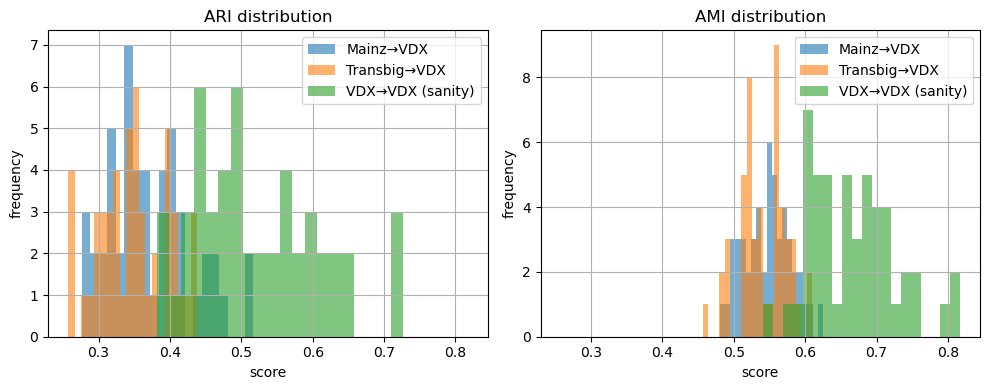

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
for label, res in results.items():
    axes[0].hist(res.ari, bins=20, alpha=0.6, label=label)
    axes[1].hist(res.ami, bins=20, alpha=0.6, label=label)

axes[0].set_title("ARI distribution")
axes[1].set_title("AMI distribution")
for ax in axes:
    ax.legend()
    ax.set_xlabel("score")
    ax.set_ylabel("frequency")
    ax.grid(True)
fig.tight_layout()
plt.show()

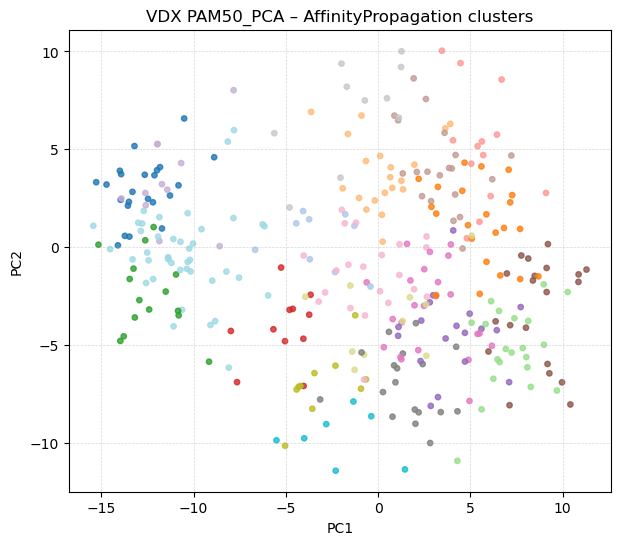

In [15]:
# single full data run cluster 
from apclust.clustering.affinity import run_affinity_propagation

vdx_full = run_affinity_propagation(pam50_pca.vdx, random_state=0)
labels = vdx_full.labels

   # PCA scatter colored by labels
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 6))
plt.scatter(
       pam50_pca.vdx.values[:, 0],
       pam50_pca.vdx.values[:, 1],
       c=labels,
       cmap="tab20",
       s=15,
       alpha=0.8,
   )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("VDX PAM50_PCA – AffinityPropagation clusters")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

In [16]:
from apclust.clustering.affinity import run_affinity_propagation

vdx_full = run_affinity_propagation(pam50_pca.vdx, random_state=0)
labels = vdx_full.labels
centers = vdx_full.cluster_centers()
print("AP clusters:", len(np.unique(labels)))

AP clusters: 21


In [18]:
from sklearn.cluster import AgglomerativeClustering

n_superclusters = 5
hc = AgglomerativeClustering(n_clusters=n_superclusters, linkage="ward")
super_labels = hc.fit_predict(centers)

major_labels = super_labels[labels]

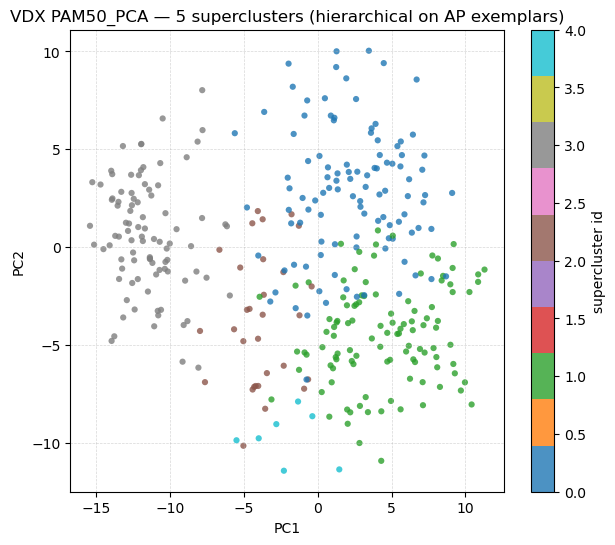

In [19]:
import matplotlib.pyplot as plt

coords = pam50_pca.vdx.values
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    coords[:, 0],
    coords[:, 1],
    c=major_labels,
    cmap="tab10",
    s=20,
    alpha=0.8,
    edgecolors="none",
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"VDX PAM50_PCA — {n_superclusters} superclusters (hierarchical on AP exemplars)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.colorbar(scatter, label="supercluster id")
plt.show()

In [20]:
pd.Series(major_labels).value_counts().sort_index().rename("sample count")

0    106
1    110
2     30
3     91
4      7
Name: sample count, dtype: int64

In [ ]:
# avg behavior across bootstrap replicability
def majority_labels(result):
    votes = pd.DataFrame(result.predicted_labels)
    return votes.mode(axis=0).iloc[0].to_numpy()
maj_labels = majority_labels(results["Mainz→VDX"])
